# edgeR & MAST
- cell cluster끼리 DEG

In [27]:
# Basic pipeline
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import loompy as lp
import sc_toolbox


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams


# Models & Calculation
from scipy.sparse import csr_matrix, issparse
from scipy.stats import median_abs_deviation as mad
import scvi
from scvi.autotune import ModelTuner
from ray import tune
import celltypist
import infercnvpy as cnv
import random

# R integration
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

# adjunctive python library
import os
from pprint import pprint
import warnings

warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', category=pd.errors.PerformanceWarning)

%matplotlib inline
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
sc.logging.print_header()

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

scanpy==1.9.8 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.1.4 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(edgeR)
library(MAST)


필요한 패키지를 로딩중입니다: limma
필요한 패키지를 로딩중입니다: SingleCellExperiment
필요한 패키지를 로딩중입니다: SummarizedExperiment
필요한 패키지를 로딩중입니다: MatrixGenerics
필요한 패키지를 로딩중입니다: matrixStats

다음의 패키지를 부착합니다: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowPro

In [ ]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
deg_out_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output/deg'

In [62]:
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))
adata

AnnData object with n_obs × n_vars = 21172 × 33697
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'sample_description', '_scvi_batch', '_scvi_labels', 'over', 'jw_diagnosis', 'jw_anno', 'ct_anno', 'ct_conf_score', 'GFP', 'leiden_res3', 'tumor_score', '_scvi_raw_norm_scaling', 'Astro-like_score', 'Astrocytes_score', 'Cycling_score', 'Endothelial_score', 'Gradient_score', 'Microglia_score', 'Mixed_score', 'Neurons_score', 'Oligodendrocytes_score', 'OPC-like_score', 'Pericytes_score', 'RE_score', 'T Cell_score', 'cell_type', 'copykat.pred', 'cnv_leiden', 'cnv_score', 'cnv_status', 'mod_cell_type', 'low_cell_type'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors',

#### 1. Data prep

In [65]:
NUM_OF_CELL_PER_DONOR = 30
def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample_id",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [133]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is a concatenation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    
    # uncomment later
    # replicate <- colData(adata_)$replicate
    
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    
    # uncomment for multifactor
    #design <- model.matrix(~ 0 + group + replicate)
    design <- model.matrix(~ 0 + group)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [63]:
adata.X = adata.layers["counts"].copy()

In [67]:
def mapper(x):
    if "LGG" in x:
        return "LGG"
    else:
        return x
adata.obs['label'] = adata.obs.sample_id.map(lambda x: mapper(x))

In [68]:
obs_to_keep = ["label", "cell_type", "sample_id"]

In [69]:
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)

Processing Astrocyte (1 out of 13)...


In [70]:
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Dropping the following samples:
['HGG']
	Processing donor 5 out of 5...

Processing COP (2 out of 13)...
Dropping the following samples:
['Control', 'LGG_1']
	Processing donor 5 out of 5...

Processing Endothelial_cell (3 out of 13)...
Dropping the following samples:
['HGG', 'LGG_1', 'LGG_2']
	Processing donor 5 out of 5...

Processing Ependymal_cell (4 out of 13)...
Dropping the following samples:
['Control']
	Processing donor 3 out of 3...

Processing Microglia (5 out of 13)...
	Processing donor 5 out of 5...

Processing NSC (6 out of 13)...
Dropping the following samples:
['HGG', 'LGG_1']
	Processing donor 5 out of 5...

Processing Neuron (7 out of 13)...
Dropping the following samples:
['Control', 'HGG', 'LGG_1', 'LGG_2']
	Processing donor 5 out of 5...

Processing OPC (8 out of 13)...
	Processing donor 5 out of 5...

Processing OPC-like (9 out of 13)...
Dropping the following samples:
['Control', 'LGG_2']
	Processing donor 5 out of 5...

Processing Oligodendrocyte (10 out of 13)..

In [97]:
adata_pb.X = csr_matrix(adata_pb.X.astype(np.float64))
adata_pb.layers['counts'] = adata_pb.X.copy()

In [98]:
print(np.max(adata_pb.X))
print(np.max(adata_pb.layers['counts']))

794588.0
794588.0


In [99]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [100]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1).astype(float)

In [101]:
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].values)

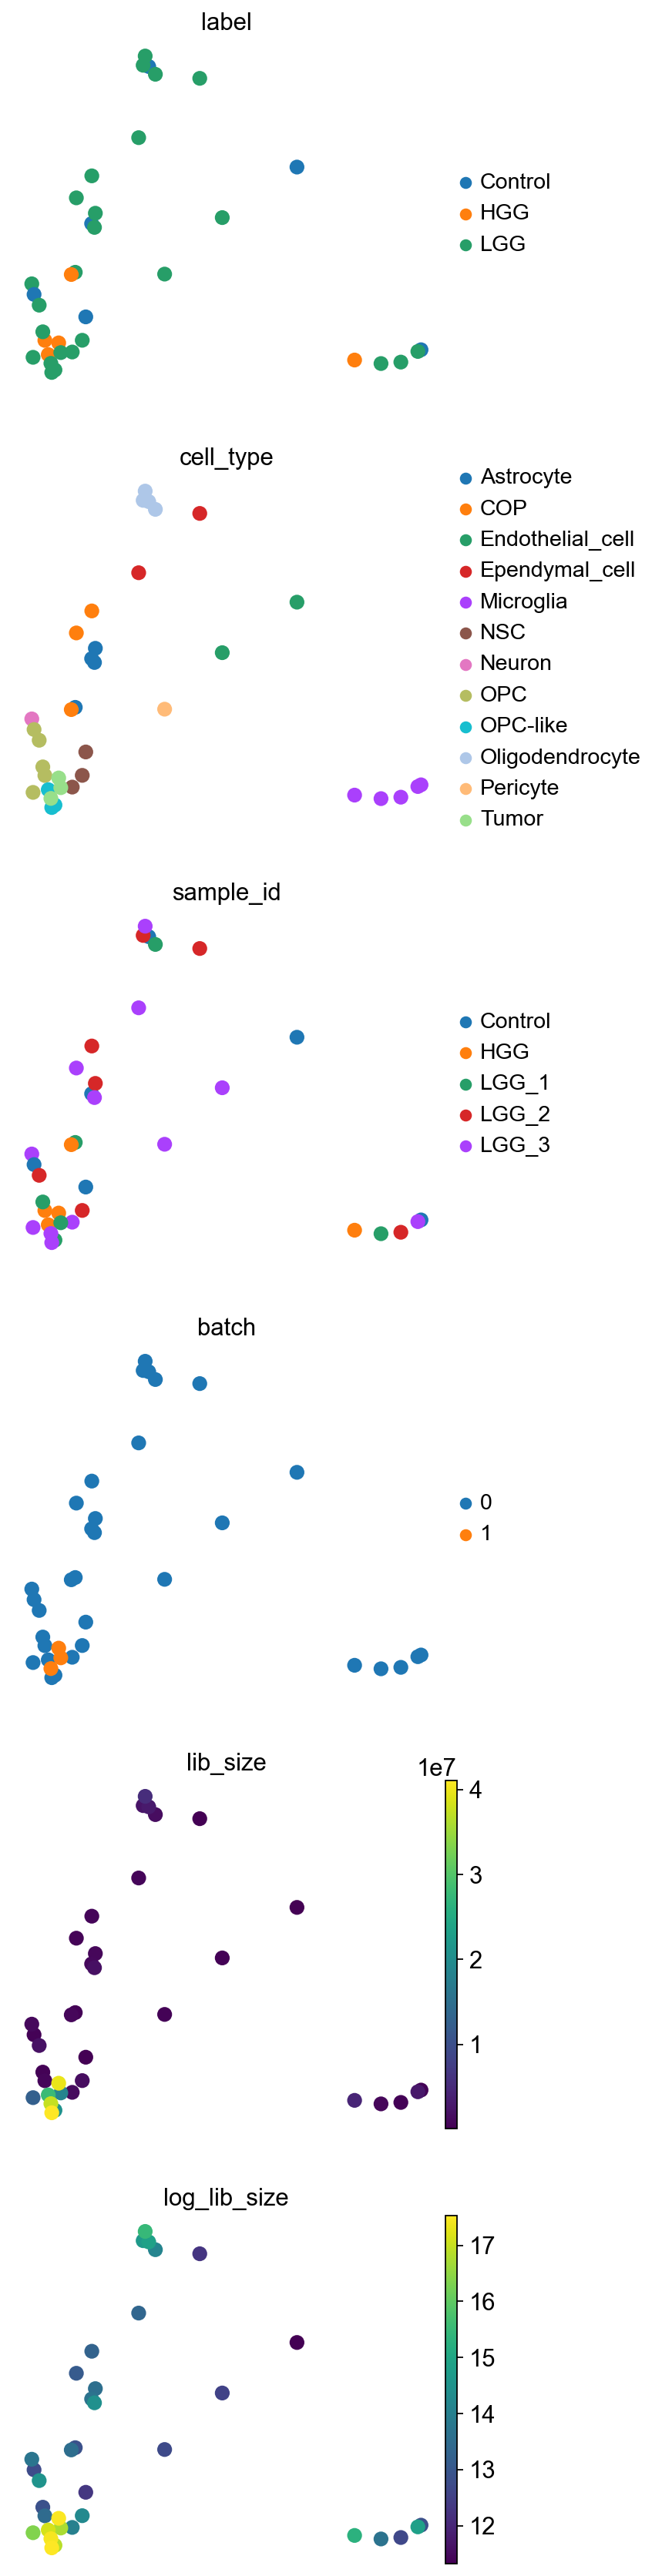

In [102]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [122]:
adata_pb.obsm['X_pca'] = csr_matrix(adata_pb.obsm['X_pca'])

In [105]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [106]:
np.max(adata_pb.X)

794588.0

#### 2. Run edgeR
- quasi-likelihood GLMs
- on specific-cell types

In [180]:
adata_pb.obs["cell_type"] = [ct.replace("-", "_") for ct in adata_pb.obs["cell_type"]]

In [181]:
%%R -i adata_pb
outs <-fit_model(adata_pb)

[1] "Dimensions before subsetting:"
[1] 33697    36
[1] ""


/Users/jiehoonk/micromamba/envs/sc/lib/python3.10/functools.py:889: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  return dispatch(args[0].__class__)(*args, **kw)


[1] "Dimensions after subsetting:"
[1] 12269    36
[1] ""


In [182]:
%%R
fit <- outs$fit
y <- outs$y

In [183]:
%%R
colnames(y$design)

 [1] "groupControl.Astrocyte"        "groupControl.Endothelial_cell"
 [3] "groupControl.Microglia"        "groupControl.NSC"             
 [5] "groupControl.OPC"              "groupControl.Oligodendrocyte" 
 [7] "groupHGG.COP"                  "groupHGG.Microglia"           
 [9] "groupHGG.OPC"                  "groupHGG.OPC_like"            
[11] "groupHGG.Tumor"                "groupLGG.Astrocyte"           
[13] "groupLGG.COP"                  "groupLGG.Endothelial_cell"    
[15] "groupLGG.Ependymal_cell"       "groupLGG.Microglia"           
[17] "groupLGG.NSC"                  "groupLGG.Neuron"              
[19] "groupLGG.OPC"                  "groupLGG.OPC_like"            
[21] "groupLGG.Oligodendrocyte"      "groupLGG.Pericyte"            
[23] "groupLGG.Tumor"               


In [192]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # Check if cell_type is not NULL
    if (!is.null(cell_type) &&
        paste0('groupLGG.', cell_type) %in% colnames(y$design) && 
        paste0('groupControl.', cell_type) %in% colnames(y$design)) {
        myContrast <- makeContrasts(paste0("groupLGG.", cell_type, "-groupControl.", cell_type), levels = y$design)
        # Perform QLF test
        qlf <- glmQLFTest(fit, contrast=myContrast)
        # Get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
        tt <- topTags(qlf, n = Inf)
        # Save in the list with the results for all the cell types
        de_per_cell_type[[cell_type]] <- tt$table
    }
}

[1] "Astrocyte"
[1] "COP"
[1] "Endothelial_cell"


/Users/jiehoonk/micromamba/envs/sc/lib/python3.10/functools.py:889: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  return dispatch(args[0].__class__)(*args, **kw)


[1] "Ependymal_cell"
[1] "Microglia"
[1] "NSC"
[1] "Neuron"
[1] "OPC"
[1] "OPC_like"
[1] "Oligodendrocyte"
[1] "Pericyte"
[1] "Tumor"


In [193]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv((deg_out_path, f"de_edgeR_{cell_type}.csv"))

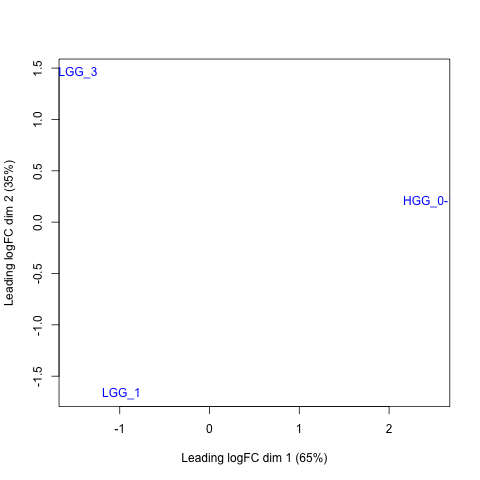

In [136]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

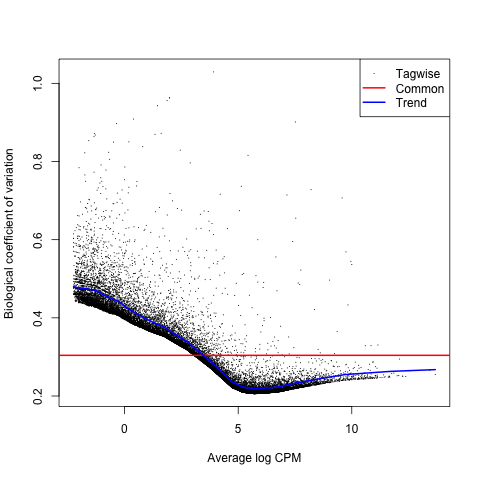

In [137]:
%%R
plotBCV(y)

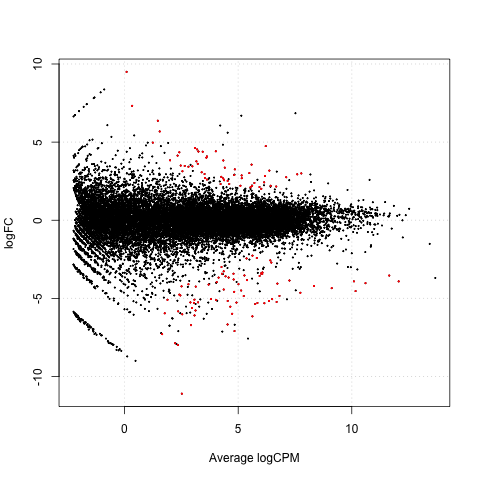

In [144]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

#### 3. Run MAST

#### 4. Visualize

In [145]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [207]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )
    
def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()


In [204]:
adata.uns.keys()

dict_keys(['GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'copykat.pred_colors', 'dea_leiden_res3', 'dendrogram_cnv_leiden', 'dendrogram_leiden_res3', 'jw_anno_colors', 'leiden', 'leiden_res3_colors', 'mod_cell_type_colors', 'neighbors', 'over_colors', 'rank_genes_groups', 'sample_id_colors', 'umap', 'log1p', 'edgeR_Astrocyte', 'edgeR_Endothelial_cell', 'edgeR_Microglia', 'edgeR_NSC', 'edgeR_OPC', 'edgeR_Oligodendrocyte'])

Plotting 0 genes...


... storing 'label' as categorical


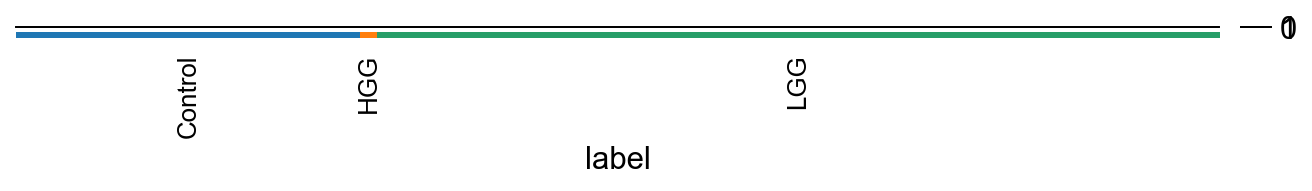

In [206]:
plot_heatmap(adata, 'edgeR_Oligodendrocyte')